In [1]:
!nvidia-smi

Tue Jul 22 20:50:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             43W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from einops import rearrange, repeat
from dataclasses import dataclass
from tqdm import trange, tqdm
from torch.utils.data import DataLoader, TensorDataset

## Data

In [3]:
# data = generate_ar_data(n_series=1, timesteps=2500, trend=0, seasonality=4, noise=0.1, level=1)
historical_data = pd.read_csv("zcyc_ranges.csv", skiprows=1, sep=";")

In [4]:
historical_data = historical_data.drop(columns="tradetime")

In [5]:
historical_data["tradedate"] = pd.to_datetime(historical_data["tradedate"], format="%d.%m.%Y")
historical_data = historical_data.set_index("tradedate")

In [6]:
historical_data = historical_data.apply(lambda x: x.str.replace(',', '.')).astype(float) / 100

<Axes: xlabel='tradedate'>

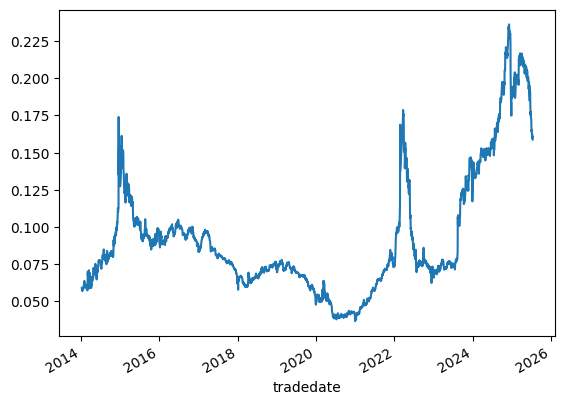

In [7]:
historical_data["period_0.25"].plot()

In [8]:
historical_data_train = np.log(historical_data[:"2024-01-01"]).diff().dropna()

In [9]:
std = historical_data_train.std()
mean = historical_data_train.mean()

In [10]:
historical_data_train = (historical_data_train - mean) / std

<Axes: >

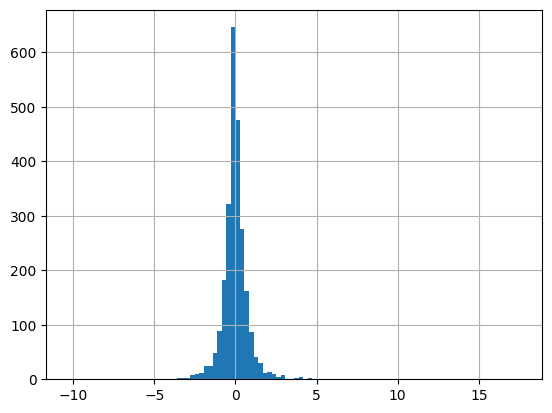

In [11]:
historical_data_train["period_0.25"].hist(bins=100)

In [81]:
class NoiseScheduler:
    def __init__(
        self,
        num_steps: int = 1000,
        beta_start: float = 1e-4,
        beta_end: float = 0.02,
        schedule: str = "cosine",
        device: str = "cuda"
    ):
        self.num_steps = num_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = torch.device(device)
        self.schedule = schedule

        # Validate schedule
        if schedule not in ["linear", "cosine"]:
            raise ValueError(f"Unknown schedule: {schedule}. Choose 'linear' or 'cosine'")

        # Initialize beta schedule
        if schedule == "linear":
            self.betas = torch.linspace(beta_start, beta_end, num_steps, device=self.device)
        else:  # cosine
            self.betas = self._cosine_beta_schedule(num_steps, s=0.008)

        # Precompute diffusion parameters
        self.alphas = 1. - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1. - self.alpha_bars)

    def _cosine_beta_schedule(self, num_steps: int, s: float = 0.008) -> torch.Tensor:
        """Cosine schedule as proposed in https://arxiv.org/abs/2102.09672"""
        steps = num_steps + 1
        x = torch.linspace(0, num_steps, steps, device=self.device)
        alphas_cumprod = torch.cos(((x / num_steps) + s) / (1 + s) * (np.pi / 2)) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]  # Normalize to start at 1
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clamp(betas, 1e-6, 0.999)  # Ensure numerical stability

    def add_noise(
        self,
        x_0: torch.Tensor,
        t: torch.Tensor,
        noise: torch.Tensor = None
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """Forward diffusion process: q(x_t | x_0)"""
        if noise is None:
            noise = torch.randn_like(x_0, device=self.device)

        # Move tensors to correct device if needed
        x_0 = x_0.to(self.device)
        t = t.to(self.device)
        noise = noise.to(self.device)

        # Get the right shape for broadcasting
        sqrt_alpha_bar = self._gather(self.sqrt_alpha_bars, t, x_0.shape)
        sqrt_one_minus_alpha_bar = self._gather(self.sqrt_one_minus_alpha_bars, t, x_0.shape)

        # Combine with noise
        x_t = sqrt_alpha_bar * x_0 + sqrt_one_minus_alpha_bar * noise
        return x_t, noise

    def step(
        self,
        model_output: torch.Tensor,
        x_t: torch.Tensor,
        t: torch.Tensor
    ) -> torch.Tensor:
        """Reverse diffusion step: p(x_{t-1} | x_t)"""
        # Ensure tensors are on correct device
        model_output = model_output.to(self.device)
        x_t = x_t.to(self.device)
        t = t.to(self.device)

        # Gather parameters for the current timestep
        alpha_t = self._gather(self.alphas, t, x_t.shape)
        alpha_bar_t = self._gather(self.alpha_bars, t, x_t.shape)
        beta_t = self._gather(self.betas, t, x_t.shape)

        # Predict x_0 and add noise if not last step
        pred_noise = model_output
        eps = 1e-6
        x_0_pred = (x_t - torch.sqrt(1. - alpha_bar_t + eps) * pred_noise) / torch.sqrt(alpha_bar_t + eps)

        # Clamp predicted x_0 to avoid extreme values
        x_0_pred = torch.clamp(x_0_pred, -10.0, 10.0)  # Adjust bounds as needed
        if t.min() > 0:  # Add noise if not last step
            noise = torch.randn_like(x_t, device=self.device)
            x_prev = torch.sqrt(alpha_t) * x_0_pred + torch.sqrt(beta_t) * noise
        else:
            x_prev = x_0_pred  # No noise for final step

        return x_prev

    def _gather(
        self,
        values: torch.Tensor,
        t: torch.Tensor,
        broadcast_shape: tuple
    ) -> torch.Tensor:
        """Utility to gather and reshape diffusion parameters for broadcasting"""
        # Gather values at timestep t
        values = values.to(self.device)[t]

        # Reshape for broadcasting (adds dummy dimensions for channels and spatial dims)
        while len(values.shape) < len(broadcast_shape):
            values = values.unsqueeze(-1)

        return values

In [82]:
class TransformerTimeDiff(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.seq_len = config.seq_len
        self.input_dim = config.input_dim
        self.hidden_dim = config.hidden_dim

        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.LayerNorm(self.hidden_dim)
        )

        # Positional embeddings (learnable)
        self.pos_embed = nn.Parameter(torch.randn(1, self.seq_len, self.hidden_dim))
        nn.init.normal_(self.pos_embed, std=0.02)  # Initialize with small values

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, self.hidden_dim),
            nn.SiLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.SiLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim)
        )

        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.hidden_dim,
            nhead=config.num_heads,
            dim_feedforward=config.ff_dim,
            dropout=config.dropout,
            batch_first=True,
            norm_first=True,
            activation=nn.GELU()  # Better than default ReLU
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=config.num_layers
        )

        # Output projection
        self.out_proj = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.SiLU(),
            nn.Linear(self.hidden_dim, self.input_dim),
            nn.Hardtanh(min_val=-1.0, max_val=1.0)  # Ensures outputs are in [-1, 1]
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (batch_size, channels, seq_len)
            t: Timestep tensor of shape (batch_size,)
        Returns:
            Output tensor of same shape as input
        """
        batch_size, channels, seq_len = x.shape

        # Rearrange and project input
        x = rearrange(x, "b c l -> b l c")
        x = self.input_proj(x)

        # Add positional embeddings
        x = x + self.pos_embed

        # Add time embeddings (broadcasted across sequence)
        t_embed = self.time_embed(t.unsqueeze(-1).float())  # (batch_size, hidden_dim)
        x = x + t_embed.unsqueeze(1)  # Add to each position

        # Transformer processing
        x = self.transformer(x)

        # Project back to input dimension
        x = self.out_proj(x)

        return rearrange(x, "b l c -> b c l")

In [83]:
def train(model, dataloader, scheduler, config, device="cuda"):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), fused=True, lr=config.lr)

    for epoch in trange(config.epochs, desc="Training epochs"):
        for batch in dataloader:
            x_0 = batch[0].float().to(device)
            B = x_0.shape[0]

            # Normalize input (critical!)
            x_0 = (x_0 - x_0.min()) / (x_0.max() - x_0.min() + 1e-6)
            x_0 = 2 * x_0 - 1  # [-1, 1]

            t = torch.randint(0, config.num_steps, (B,), device=device)
            x_t, noise = scheduler.add_noise(x_0, t)

            pred_noise = model(x_t, t)
            loss = F.mse_loss(pred_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Debug logging
            if torch.isnan(loss).any():
                print("NaN detected in loss! Terminating.")
                break

        print(f"\nEpoch {epoch}, Loss: {loss.item():.4f}")

In [84]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

In [85]:
@torch.no_grad()
def sample(model, scheduler, config, num_samples=1, device="cuda"):
    model.eval()
    x_t = torch.randn((num_samples, config.input_dim, config.seq_len), device=device)

    for t in reversed(range(config.num_steps)):
        t_tensor = torch.full((num_samples,), t, device=device)
        pred_noise = model(x_t, t_tensor)
        x_t = scheduler.step(pred_noise, x_t, t_tensor)

    return x_t

In [86]:
@dataclass
class Config():
    seq_len=252
    lr=1e-4
    input_dim=12
    num_steps=1000
    hidden_dim=16
    batch_size=128
    epochs=100

config = Config()
device = "cuda" if torch.cuda.is_available() else 'cpu'

scheduler = NoiseScheduler(num_steps=config.num_steps, schedule="cosine", device=device)
model = TransformerTimeDiff(config).to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [87]:
device

'cuda'

In [88]:
data_tensor = torch.Tensor(create_sequences(historical_data_train, 252))
data_tensor = data_tensor.permute(0, 2, 1)
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)

In [89]:
# Train
train(
    model=model,
    dataloader=dataloader,
    scheduler=scheduler,
    config=config,
    device=device
)

Training epochs:   1%|          | 1/100 [00:01<02:27,  1.49s/it]


Epoch 0, Loss: 1.7922


Training epochs:   2%|▏         | 2/100 [00:02<02:17,  1.41s/it]


Epoch 1, Loss: 1.7123


Training epochs:   3%|▎         | 3/100 [00:04<02:14,  1.39s/it]


Epoch 2, Loss: 1.6668


Training epochs:   4%|▍         | 4/100 [00:05<02:12,  1.38s/it]


Epoch 3, Loss: 1.6808


Training epochs:   5%|▌         | 5/100 [00:06<02:10,  1.37s/it]


Epoch 4, Loss: 1.6185


Training epochs:   6%|▌         | 6/100 [00:08<02:09,  1.37s/it]


Epoch 5, Loss: 1.5082


Training epochs:   7%|▋         | 7/100 [00:09<02:08,  1.38s/it]


Epoch 6, Loss: 1.3876


Training epochs:   8%|▊         | 8/100 [00:11<02:06,  1.37s/it]


Epoch 7, Loss: 1.3668


Training epochs:   9%|▉         | 9/100 [00:12<02:04,  1.37s/it]


Epoch 8, Loss: 1.3120


Training epochs:  10%|█         | 10/100 [00:13<02:03,  1.37s/it]


Epoch 9, Loss: 1.2202


Training epochs:  11%|█         | 11/100 [00:15<02:02,  1.37s/it]


Epoch 10, Loss: 1.1766


Training epochs:  12%|█▏        | 12/100 [00:16<02:01,  1.38s/it]


Epoch 11, Loss: 1.1747


Training epochs:  13%|█▎        | 13/100 [00:17<02:00,  1.39s/it]


Epoch 12, Loss: 1.1593


Training epochs:  14%|█▍        | 14/100 [00:19<01:59,  1.38s/it]


Epoch 13, Loss: 1.1463


Training epochs:  15%|█▌        | 15/100 [00:20<01:57,  1.39s/it]


Epoch 14, Loss: 1.0894


Training epochs:  16%|█▌        | 16/100 [00:22<01:56,  1.39s/it]


Epoch 15, Loss: 1.0655


Training epochs:  17%|█▋        | 17/100 [00:23<01:55,  1.39s/it]


Epoch 16, Loss: 1.0170


Training epochs:  18%|█▊        | 18/100 [00:24<01:53,  1.39s/it]


Epoch 17, Loss: 1.0021


Training epochs:  19%|█▉        | 19/100 [00:26<01:52,  1.39s/it]


Epoch 18, Loss: 0.9892


Training epochs:  20%|██        | 20/100 [00:27<01:51,  1.39s/it]


Epoch 19, Loss: 0.9749


Training epochs:  21%|██        | 21/100 [00:29<01:49,  1.39s/it]


Epoch 20, Loss: 0.9690


Training epochs:  22%|██▏       | 22/100 [00:30<01:48,  1.39s/it]


Epoch 21, Loss: 0.9570


Training epochs:  23%|██▎       | 23/100 [00:31<01:47,  1.39s/it]


Epoch 22, Loss: 0.9412


Training epochs:  24%|██▍       | 24/100 [00:33<01:46,  1.40s/it]


Epoch 23, Loss: 0.9240


Training epochs:  25%|██▌       | 25/100 [00:34<01:45,  1.40s/it]


Epoch 24, Loss: 0.8729


Training epochs:  26%|██▌       | 26/100 [00:36<01:43,  1.40s/it]


Epoch 25, Loss: 0.8604


Training epochs:  27%|██▋       | 27/100 [00:37<01:42,  1.40s/it]


Epoch 26, Loss: 0.8356


Training epochs:  28%|██▊       | 28/100 [00:38<01:41,  1.40s/it]


Epoch 27, Loss: 0.8323


Training epochs:  29%|██▉       | 29/100 [00:40<01:39,  1.40s/it]


Epoch 28, Loss: 0.8092


Training epochs:  30%|███       | 30/100 [00:41<01:38,  1.40s/it]


Epoch 29, Loss: 0.7987


Training epochs:  31%|███       | 31/100 [00:43<01:37,  1.41s/it]


Epoch 30, Loss: 0.7881


Training epochs:  32%|███▏      | 32/100 [00:44<01:35,  1.41s/it]


Epoch 31, Loss: 0.7793


Training epochs:  33%|███▎      | 33/100 [00:45<01:34,  1.41s/it]


Epoch 32, Loss: 0.7658


Training epochs:  34%|███▍      | 34/100 [00:47<01:33,  1.41s/it]


Epoch 33, Loss: 0.7590


Training epochs:  35%|███▌      | 35/100 [00:48<01:31,  1.41s/it]


Epoch 34, Loss: 0.7531


Training epochs:  36%|███▌      | 36/100 [00:50<01:30,  1.41s/it]


Epoch 35, Loss: 0.7432


Training epochs:  37%|███▋      | 37/100 [00:51<01:28,  1.41s/it]


Epoch 36, Loss: 0.7410


Training epochs:  38%|███▊      | 38/100 [00:53<01:27,  1.41s/it]


Epoch 37, Loss: 0.7301


Training epochs:  39%|███▉      | 39/100 [00:54<01:25,  1.41s/it]


Epoch 38, Loss: 0.7304


Training epochs:  40%|████      | 40/100 [00:55<01:25,  1.42s/it]


Epoch 39, Loss: 0.7145


Training epochs:  41%|████      | 41/100 [00:57<01:24,  1.43s/it]


Epoch 40, Loss: 0.7147


Training epochs:  42%|████▏     | 42/100 [00:58<01:26,  1.49s/it]


Epoch 41, Loss: 0.6936


Training epochs:  43%|████▎     | 43/100 [01:00<01:25,  1.50s/it]


Epoch 42, Loss: 0.6942


Training epochs:  44%|████▍     | 44/100 [01:01<01:22,  1.47s/it]


Epoch 43, Loss: 0.6918


Training epochs:  45%|████▌     | 45/100 [01:03<01:20,  1.45s/it]


Epoch 44, Loss: 0.6804


Training epochs:  46%|████▌     | 46/100 [01:04<01:17,  1.44s/it]


Epoch 45, Loss: 0.6740


Training epochs:  47%|████▋     | 47/100 [01:06<01:15,  1.43s/it]


Epoch 46, Loss: 0.6678


Training epochs:  48%|████▊     | 48/100 [01:07<01:14,  1.42s/it]


Epoch 47, Loss: 0.6634


Training epochs:  49%|████▉     | 49/100 [01:08<01:12,  1.42s/it]


Epoch 48, Loss: 0.6541


Training epochs:  50%|█████     | 50/100 [01:10<01:10,  1.42s/it]


Epoch 49, Loss: 0.6636


Training epochs:  51%|█████     | 51/100 [01:11<01:09,  1.42s/it]


Epoch 50, Loss: 0.6507


Training epochs:  52%|█████▏    | 52/100 [01:13<01:07,  1.41s/it]


Epoch 51, Loss: 0.6441


Training epochs:  53%|█████▎    | 53/100 [01:14<01:06,  1.41s/it]


Epoch 52, Loss: 0.6385


Training epochs:  54%|█████▍    | 54/100 [01:15<01:04,  1.40s/it]


Epoch 53, Loss: 0.6526


Training epochs:  55%|█████▌    | 55/100 [01:17<01:03,  1.40s/it]


Epoch 54, Loss: 0.6405


Training epochs:  56%|█████▌    | 56/100 [01:18<01:01,  1.40s/it]


Epoch 55, Loss: 0.6528


Training epochs:  57%|█████▋    | 57/100 [01:20<01:00,  1.40s/it]


Epoch 56, Loss: 0.6339


Training epochs:  58%|█████▊    | 58/100 [01:21<00:58,  1.40s/it]


Epoch 57, Loss: 0.6317


Training epochs:  59%|█████▉    | 59/100 [01:22<00:57,  1.41s/it]


Epoch 58, Loss: 0.6332


Training epochs:  60%|██████    | 60/100 [01:24<00:56,  1.41s/it]


Epoch 59, Loss: 0.6249


Training epochs:  61%|██████    | 61/100 [01:25<00:54,  1.40s/it]


Epoch 60, Loss: 0.6259


Training epochs:  62%|██████▏   | 62/100 [01:27<00:53,  1.40s/it]


Epoch 61, Loss: 0.6194


Training epochs:  63%|██████▎   | 63/100 [01:28<00:51,  1.40s/it]


Epoch 62, Loss: 0.6192


Training epochs:  64%|██████▍   | 64/100 [01:29<00:50,  1.41s/it]


Epoch 63, Loss: 0.6233


Training epochs:  65%|██████▌   | 65/100 [01:31<00:49,  1.41s/it]


Epoch 64, Loss: 0.6134


Training epochs:  66%|██████▌   | 66/100 [01:32<00:47,  1.40s/it]


Epoch 65, Loss: 0.6077


Training epochs:  67%|██████▋   | 67/100 [01:34<00:46,  1.40s/it]


Epoch 66, Loss: 0.6171


Training epochs:  68%|██████▊   | 68/100 [01:35<00:44,  1.41s/it]


Epoch 67, Loss: 0.6189


Training epochs:  69%|██████▉   | 69/100 [01:37<00:43,  1.40s/it]


Epoch 68, Loss: 0.6107


Training epochs:  70%|███████   | 70/100 [01:38<00:43,  1.46s/it]


Epoch 69, Loss: 0.6001


Training epochs:  71%|███████   | 71/100 [01:39<00:41,  1.44s/it]


Epoch 70, Loss: 0.6007


Training epochs:  72%|███████▏  | 72/100 [01:41<00:39,  1.42s/it]


Epoch 71, Loss: 0.5993


Training epochs:  73%|███████▎  | 73/100 [01:42<00:38,  1.42s/it]


Epoch 72, Loss: 0.5987


Training epochs:  74%|███████▍  | 74/100 [01:44<00:36,  1.42s/it]


Epoch 73, Loss: 0.5976


Training epochs:  75%|███████▌  | 75/100 [01:45<00:35,  1.42s/it]


Epoch 74, Loss: 0.6001


Training epochs:  76%|███████▌  | 76/100 [01:47<00:35,  1.46s/it]


Epoch 75, Loss: 0.5976


Training epochs:  77%|███████▋  | 77/100 [01:48<00:34,  1.51s/it]


Epoch 76, Loss: 0.5839


Training epochs:  78%|███████▊  | 78/100 [01:50<00:32,  1.48s/it]


Epoch 77, Loss: 0.5904


Training epochs:  79%|███████▉  | 79/100 [01:51<00:30,  1.46s/it]


Epoch 78, Loss: 0.5835


Training epochs:  80%|████████  | 80/100 [01:53<00:28,  1.44s/it]


Epoch 79, Loss: 0.5838


Training epochs:  81%|████████  | 81/100 [01:54<00:27,  1.43s/it]


Epoch 80, Loss: 0.5799


Training epochs:  82%|████████▏ | 82/100 [01:55<00:25,  1.42s/it]


Epoch 81, Loss: 0.5813


Training epochs:  83%|████████▎ | 83/100 [01:57<00:24,  1.42s/it]


Epoch 82, Loss: 0.5711


Training epochs:  84%|████████▍ | 84/100 [01:58<00:22,  1.42s/it]


Epoch 83, Loss: 0.5744


Training epochs:  85%|████████▌ | 85/100 [02:00<00:21,  1.42s/it]


Epoch 84, Loss: 0.5657


Training epochs:  86%|████████▌ | 86/100 [02:01<00:19,  1.41s/it]


Epoch 85, Loss: 0.5701


Training epochs:  87%|████████▋ | 87/100 [02:02<00:18,  1.41s/it]


Epoch 86, Loss: 0.5493


Training epochs:  88%|████████▊ | 88/100 [02:04<00:16,  1.41s/it]


Epoch 87, Loss: 0.5584


Training epochs:  89%|████████▉ | 89/100 [02:05<00:15,  1.41s/it]


Epoch 88, Loss: 0.5537


Training epochs:  90%|█████████ | 90/100 [02:07<00:14,  1.41s/it]


Epoch 89, Loss: 0.5450


Training epochs:  91%|█████████ | 91/100 [02:08<00:12,  1.41s/it]


Epoch 90, Loss: 0.5460


Training epochs:  92%|█████████▏| 92/100 [02:09<00:11,  1.41s/it]


Epoch 91, Loss: 0.5413


Training epochs:  93%|█████████▎| 93/100 [02:11<00:09,  1.41s/it]


Epoch 92, Loss: 0.5509


Training epochs:  94%|█████████▍| 94/100 [02:12<00:08,  1.41s/it]


Epoch 93, Loss: 0.5395


Training epochs:  95%|█████████▌| 95/100 [02:14<00:07,  1.41s/it]


Epoch 94, Loss: 0.5464


Training epochs:  96%|█████████▌| 96/100 [02:15<00:05,  1.41s/it]


Epoch 95, Loss: 0.5362


Training epochs:  97%|█████████▋| 97/100 [02:16<00:04,  1.41s/it]


Epoch 96, Loss: 0.5399


Training epochs:  98%|█████████▊| 98/100 [02:18<00:02,  1.41s/it]


Epoch 97, Loss: 0.5332


Training epochs:  99%|█████████▉| 99/100 [02:19<00:01,  1.40s/it]


Epoch 98, Loss: 0.5330


Training epochs: 100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


Epoch 99, Loss: 0.5240


In [90]:
historical_data_validate = historical_data["2024-01-01":].iloc[:253,:]

In [ ]:
# Generate
synthetic_samples = sample(model, scheduler, config, num_samples=1_00)
synthetic_samples = synthetic_samples.permute(0, 2, 1)

In [ ]:
# synthetic_samples

/tmp/ipython-input-74-99251181.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sim_data = synthetic_samples[:, :, i].detach().to("cpu").numpy() * std[i] - mean[i]


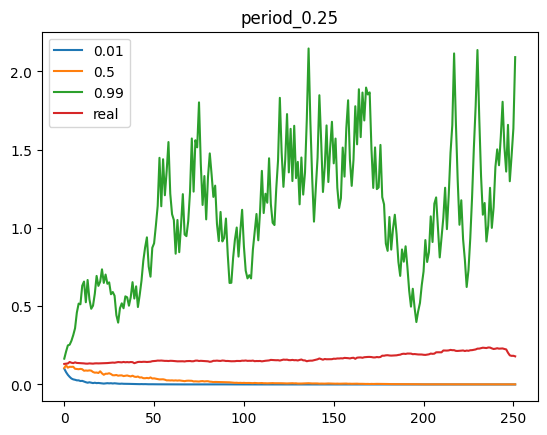

In [74]:
# for i in range(historical_data_validate.shape[1]):
i=0

sim_data = synthetic_samples[:, :, i].detach().to("cpu").numpy() * std[i] - mean[i]
sim_data = pd.DataFrame(sim_data)
sim_data = np.exp(np.cumsum(sim_data.T, axis=0))
sim_data = historical_data_validate.iloc[0, i] * sim_data

sim_data.quantile([0.01, 0.5, 0.99], axis=1).T.plot()
plt.plot(historical_data_validate.iloc[1:, i].values, label="real")
plt.legend()
plt.title(historical_data_validate.columns[i])
plt.show()

<Axes: >

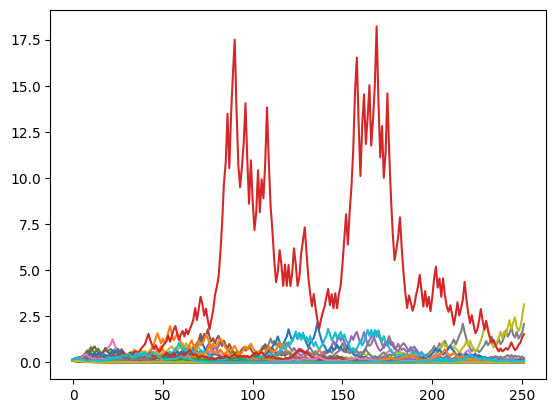

In [75]:
sim_data.plot(legend=False)